# Final Assignment  :----
---

# Brain Tumor Segmentation with UNET

In [ ]:
# Importing the libraries that are needed....
import os   # it provides functions for interacting with the operating system.
import random # used to generate random number
from os import listdir  # returns a list containing the names of the entries in the directory given by path
import glob  #  used to find the files and folders whose names follow a specific pattern
import shutil  # helps in automating the process of copying and removal of files and directories
import pandas as pd
import numpy  as np
from skimage.transform import resize # for resizing the images
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow # used to display data as an image
from sklearn.model_selection import train_test_split # used for splitting a single dataset for two different purposes: training and testing
import tensorflow as tf # for model
from tensorflow import keras  # used for fast experimentation
import keras.backend as K
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from tensorflow.keras.optimizers import Adam
import natsort  # implements natural order sorting in Python
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

In [ ]:
# Since the data is stored on drive , we will first mount at the location in drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Defining paths

path_images = "/content/drive/MyDrive/Unet_data/images/"
path_masks = "/content/drive/MyDrive/Unet_data/masks/"

In [ ]:
# Images size , color and channel are initialized..

img_row = 224
img_col = 224
img_chan = 1
input_size = (img_row, img_col, img_chan)

In [ ]:
# Loading the data
img_list = listdir(path_images)    # returns a list containing the names of the entries in the directory given by path
img_list = natsort.natsorted(img_list)  # implements natural order sorting in Python
mask_list1 = listdir(path_masks)
mask_list1 = natsort.natsorted(mask_list1)
num_img = len(img_list)   # length
num_img   # number of images 

500

In [ ]:
# Loading functions and images are Normalized

def img_load(dir_path, img_list, img_array):
    for i in range(num_img):
        tmp_img = image.load_img(os.path.join(dir_path, img_list[i]), target_size=(img_row, img_col, img_chan))  # loading images
        img = image.img_to_array(tmp_img)
        img_array[i] = img[:,:,0]/255.0 

    # Dimensions of the arrays are expanded...

    img_array = np.expand_dims(img_array, axis=3)  # used to expand the shape of an array. 
    return img_array

In [ ]:
# Arrays are initialized....

img = np.zeros((num_img, img_row, img_col))
mask = np.zeros((num_img, img_row, img_col))

img = img_load(path_images, img_list, img)
mask = img_load(path_masks, mask_list1, mask)

print("Images", img.shape)
print("Masks", mask.shape)



Images (500, 224, 224, 1)
Masks (500, 224, 224, 1)


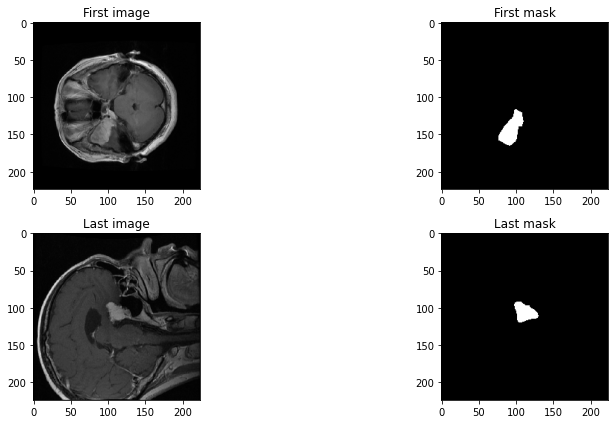

In [ ]:
# Plotting the first and the last images...

first = 0
last = 499
plt.figure(figsize = (14,6))  # creates several figures in the same script
plt.subplot(221)  # adds subplot to a current figure at the specified grid position
plt.imshow(np.squeeze(img[first]), cmap = "gray")  # used to remove single-dimensional entries from the shape of an array
plt.title('First image')
plt.subplot(222)
plt.imshow(np.squeeze(mask[first]), cmap = "gray")
plt.title('First mask')
plt.subplot(223)
plt.imshow(np.squeeze(img[last]), cmap = "gray")
plt.title('Last image')
plt.subplot(224)
plt.imshow(np.squeeze(mask[last]), cmap = "gray")
plt.title('Last mask')
plt.tight_layout()  # used to automatically adjust the subplot
plt.show()

In [ ]:
# Data is splitted into training and validation split in 90:10 ratio

X_train, X_valid, y_train, y_valid = train_test_split(img, mask, test_size=0.1, random_state=42)  # used for splitting a single dataset for two different purposes: training and testing

In [ ]:
# Function to calculate the DSC score

def dsc(y_true, y_pred):
    smooth = 1.
    # masks
    y_true_fm = K.flatten(y_true)  # used to flatten the input.
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth) 
    return score

In [ ]:
# Model

input = Input((img_row, img_col, img_chan))

# Contracting path (Encoder)

# This is the path where the complex features gets extracted from the images and a low resolution is created ...

c1 = Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding = "same")(input)  # this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs
c1 = Dropout(0.1)(c1)   # it randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting
c1 = Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding = "same")(c1)
p1 = MaxPooling2D((2,2))(c1)   # it selects the maximum element from the region of the feature map covered by the filter

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)


c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

(8,8,256)

# Expansive path (Decoder)

# This is the path where the low resoltuion is converted into high resolution...

# The intermediate results of the above paths are concatenated here to construct an accuracte boundary for the segmentation...

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)   # it filter's weights and flips them by 180 degrees
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[input], outputs=[outputs])  # Model groups layers into an object with training and inference features
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dsc])  # Once the model is created, we can config the model with losses and metrics with model.compile()
model.summary()  # It prints table to stdout

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 224, 224, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# Fitting the model

# model.fit() is used for training the Keras model by passing the required training data and iterating it for a necessary number of times as specified by epoch, which aims to update the mathematical variables present internally by the model

results = model.fit(X_train, y_train, batch_size=16, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
29/29 [==============================] - 238s 8s/step - loss: 0.0589 - dsc: 0.1262 - val_loss: 0.0951 - val_dsc: 0.1504
Epoch 2/20
29/29 [==============================] - 244s 8s/step - loss: 0.0443 - dsc: 0.2629 - val_loss: 0.1299 - val_dsc: 0.1436
Epoch 3/20
29/29 [==============================] - 239s 8s/step - loss: 0.0423 - dsc: 0.2991 - val_loss: 0.0583 - val_dsc: 0.2644
Epoch 4/20
29/29 [==============================] - 237s 8s/step - loss: 0.0364 - dsc: 0.3475 - val_loss: 0.0603 - val_dsc: 0.2606
Epoch 5/20
29/29 [==============================] - 239s 8s/step - loss: 0.0341 - dsc: 0.3767 - val_loss: 0.0370 - val_dsc: 0.3762
Epoch 6/20
29/29 [==============================] - 238s 8s/step - loss: 0.0350 - dsc: 0.3786 - val_loss: 0.0463 - val_dsc: 0.3109
Epoch 7/20
29/29 [==============================] - 236s 8s/step - loss: 0.0284 - dsc: 0.4346 - val_loss: 0.0379 - val_dsc: 0.3829
Epoch 8/20
29/29 [==============================] - 238s 8s/step - loss: 0.0272 - d

In [ ]:
print(results)

In [ ]:
pred_train = model.predict(X_train, verbose=1)  # the predict () method operates on top of the trained model, mapping and predicting the labels for the data to be tested using the learned label.
pred_val = model.predict(X_valid, verbose=1)  #  It returns the labels of the data supplied as an argument based on the model’s learned or trained data.

2/2 [==============================] - 6s 2s/step


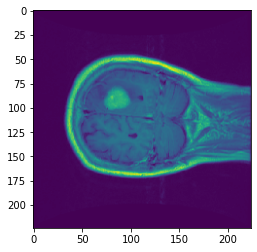

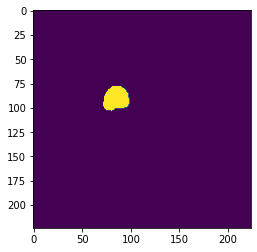

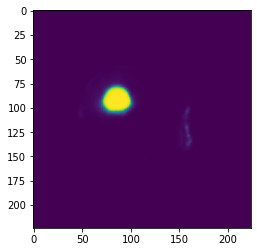

In [ ]:
#Comparing the predicted data with the actual data

ix = random.randint(0, len(pred_train))

# numpy.squeeze() function is used when we want to remove single-dimensional entries from the shape of an array

imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(pred_train[ix]))
plt.show()

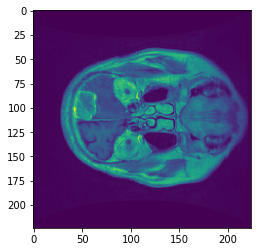

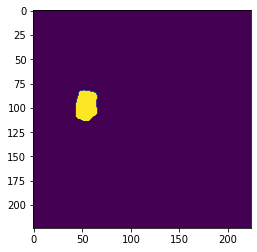

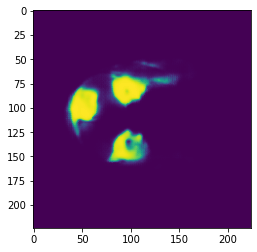

In [ ]:
imshow(np.squeeze(X_valid[0]))
plt.show()
imshow(np.squeeze(y_valid[0]))
plt.show()
imshow(np.squeeze(pred_val[0]))
plt.show()

--------------------  XXXXX  -------------------